<a href="https://colab.research.google.com/github/Raphael-Vargas-Moya/PDI-Lab/blob/main/Pr%C3%A1ctica_7_Segmentaci%C3%B3n_%C3%B3ptima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Práctica 7 - Segmentación óptima**

---

Primero importamos las librerías a usar en la práctica.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize # para algoritmo de optimización

Para obtener la imagen requisitada en la práctica (https://github.com/dilp90/PDI/blob/main/Imagenes/Te-me_0015.jpg), usamos el comando `!wget` para descargar la imagen en el almacenamiento de Colab bajo el nombre de "tacTumor.jpg"

In [ ]:
!wget https://github.com/dilp90/PDI/blob/main/Imagenes/Te-me_0015.jpg?raw=true -O /content/tacTumor.jpg

--2025-11-24 13:04:21--  https://github.com/dilp90/PDI/blob/main/Imagenes/Te-me_0015.jpg?raw=true
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/dilp90/PDI/raw/refs/heads/main/Imagenes/Te-me_0015.jpg [following]
--2025-11-24 13:04:21--  https://github.com/dilp90/PDI/raw/refs/heads/main/Imagenes/Te-me_0015.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dilp90/PDI/refs/heads/main/Imagenes/Te-me_0015.jpg [following]
--2025-11-24 13:04:21--  https://raw.githubusercontent.com/dilp90/PDI/refs/heads/main/Imagenes/Te-me_0015.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connect

---

## **Segmentación sencilla**

Como la imagen de base está en escala de grises, no podemos obtener valores RGB distintos, por lo que cada canal tendrá la misma magnitud pero en el canal de su respectivo color. Este paso y los siguientes no son necesarios para la segmentación sencilla ni para la óptima, sin embargo, como se solicita realizar los mismos pasos, se dejan incluidos, comentando los resultados.

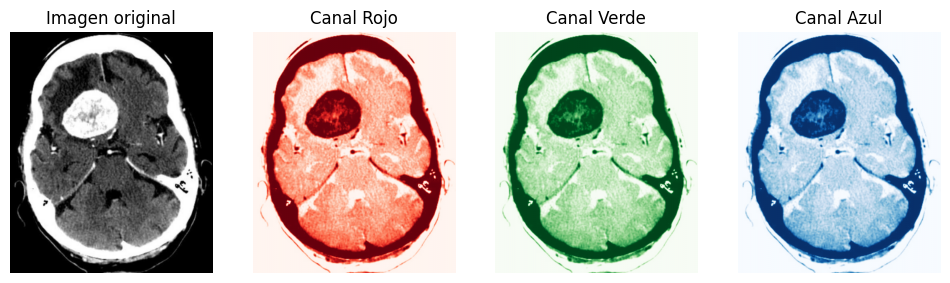

In [ ]:
# Cargar imagen a color
img = cv2.imread('/content/tacTumor.jpg')  # Cambia 'imagen.jpg' por la ruta de tu imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR (OpenCV) a RGB

# Separar canales
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

# Mostrar los canales por separado
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(R, cmap='Reds')
plt.title('Canal Rojo')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul')
plt.axis('off')
plt.show()

Como podemos observar, la imagen promediada es igual a la original, ya que los canales eran copias de la misma magnitud, divididos en partes iguales y combinados posteriormente.

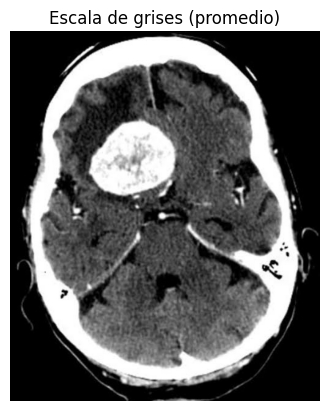

In [ ]:
# Convertir a escala de grises promediando canales
gray_avg = ((R.astype(np.float32) + G + B) / 3).astype(np.uint8)

# Mostrar imagen en escala de grises
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')
plt.show()

Finalmentet, la segmentación simple se realiza seleccionando un umbral. Así, los valores menores a dicho umbral pasan a valer `0` y los valores mayores al umbral pasan a valer `1` (o el valor máximo de intensidad de la imagen, en este caso, `255`)

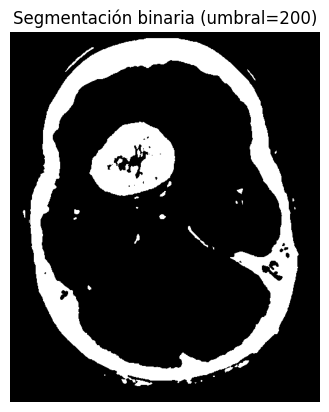

In [ ]:
# Umbral para segmentación
umbral = 200
_, segmentada = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)

# Mostrar imagen segmentada
plt.imshow(segmentada, cmap='gray')
plt.title(f'Segmentación binaria (umbral={umbral})')
plt.axis('off')
plt.show()

---

## **Segmentación óptima**

Para la segmentación óptima, repetimos el mismo proceso de cargar la imagen y dividirla en canales como en la segmentación simple.

In [ ]:
# Cargar imagen y convertir de BGR a RGB
img = cv2.imread('/content/tacTumor.jpg')  # Cambia el nombre de la imagen
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

Aquí creamos y utilizamos la función `grayscale_variance` y `minimize` para determinar los valores de los coeficientes óptimos para los canales RGB, utilizando el método de opttimización SLSQP.

In [ ]:
# Normalizar canales entre 0 y 1
R_norm = R.astype(np.float32) / 255
G_norm = G.astype(np.float32) / 255
B_norm = B.astype(np.float32) / 255

# Función objetivo: varianza negativa (porque minimize() minimiza)
def grayscale_variance(weights):
    w_r, w_g, w_b = weights
    gray = w_r * R_norm + w_g * G_norm + w_b * B_norm
    gray_normalized = (gray - gray.min()) / (gray.max() - gray.min())
    return -np.var(gray_normalized)  # Negativo para maximizar

# Restricción: suma de pesos debe ser 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Límites de cada peso: entre 0 y 1
bounds = [(0, 1), (0, 1), (0, 1)]

# Valor inicial
initial_weights = [0.33, 0.33, 0.34]

# Optimización
result = minimize(grayscale_variance, initial_weights, method='SLSQP',
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Pesos óptimos:", optimal_weights)

Pesos óptimos: [0.33 0.33 0.34]


Y como podemos ver, los pesos son iguales para los tres canales (1/3 para cada canal y uno se redondea a 0.34 debido a que tienen que sumar 1), por lo que el resultado en este caso es el mismo que en la segmentación simple.

Posteriormente, comparamos los resultados de ambas segmentaciones.

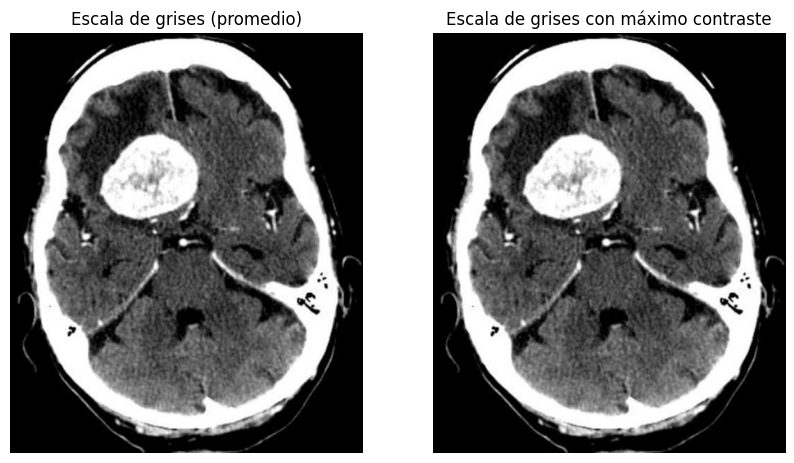

In [ ]:
# Crear imagen en escala de grises con pesos óptimos
gray_optimal = optimal_weights[0] * R_norm + optimal_weights[1] * G_norm + optimal_weights[2] * B_norm
gray_optimal = (gray_optimal * 255).astype(np.uint8)

# Mostrar resultado
# Imagen obtenida de manera directa o sencilla
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')

# Imagen obtenida de manera óptima
plt.subplot(1, 2, 2)
plt.imshow(gray_optimal, cmap='gray')
plt.title('Escala de grises con máximo contraste')
plt.axis('off')
plt.show()

Y como podemos apreciar, las imágenes son idénticas.

---

# **Limpieza y análisis de la imagen**

Para eliminar el ruido de la imagen y dejar los contornos del cráneo y el tumor, ocupamos las funciones `erode` y `dilate` para eliminar los puntos de ruido sin modificar mucho las áreas de interés.

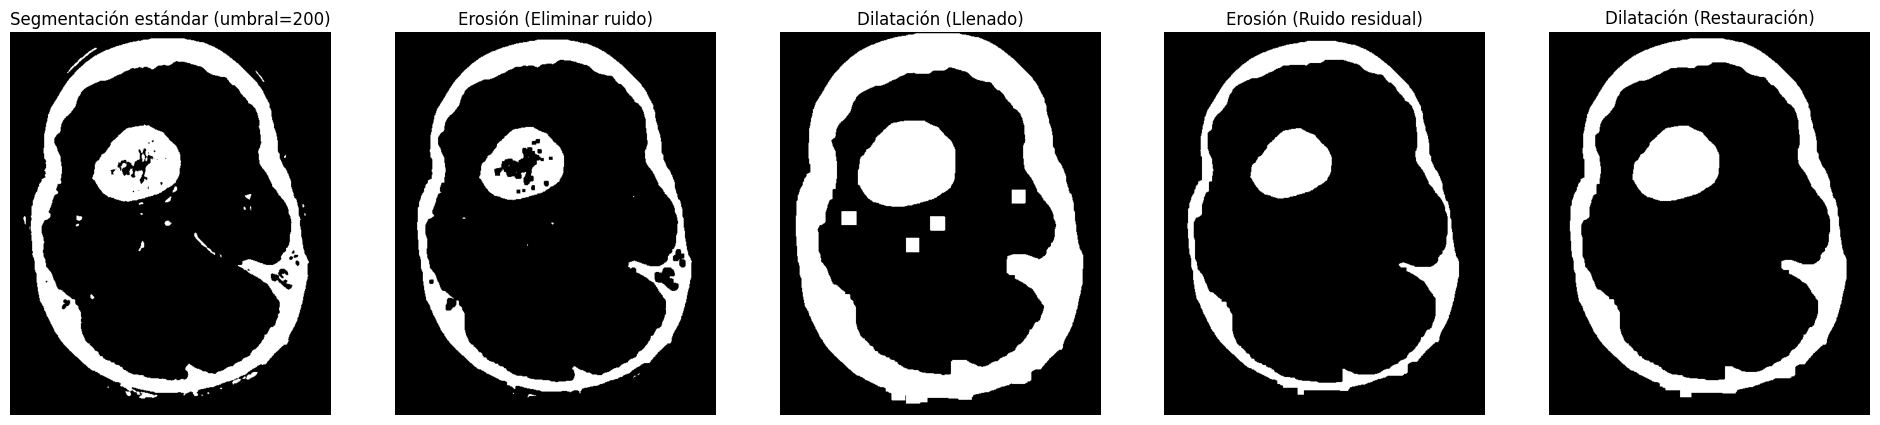

In [ ]:
# Segmentar la imagen, erosionar y dilatar
umbral = 200
_, seg_standard = cv2.threshold(gray_avg, umbral, 255, cv2.THRESH_BINARY)
erode1 = cv2.erode(seg_standard, None, iterations=2)
dilate1 = cv2.dilate(erode1, None, iterations=10)
erode2 = cv2.erode(dilate1, None, iterations=12)
noiseFree = cv2.dilate(erode2, None, iterations=4)


# Mostrar resultado
# Imagen segmentada
plt.figure(figsize=(24, 10))
plt.subplot(1, 5, 1)
plt.imshow(seg_standard, cmap='gray')
plt.title(f'Segmentación estándar (umbral={umbral})')
plt.axis('off')

# Erosión
plt.subplot(1, 5, 2)
plt.imshow(erode1, cmap='gray')
plt.title(f'Erosión (Eliminar ruido)')
plt.axis('off')

# Dilatación
plt.subplot(1, 5, 3)
plt.imshow(dilate1, cmap='gray')
plt.title(f'Dilatación (Llenado)')
plt.axis('off')

# Erosión
plt.subplot(1, 5, 4)
plt.imshow(erode2, cmap='gray')
plt.title(f'Erosión (Ruido residual)')
plt.axis('off')

# Dilatación
plt.subplot(1, 5, 5)
plt.imshow(noiseFree, cmap='gray')
plt.title(f'Dilatación (Restauración)')
plt.axis('off')
plt.show()

Para obtener el área del tumor, primero tenemos que aislarlo. Observando las coordenadas de la imagen, vemos que el tumor está entre `100-300` en el eje horizaontal, y también en `100-300` en el eje vertical, por lo que podemos hacer una máscara circular de `radio = 100` centrada en `(200, 200)` y aplicarla a la imagen limpia.

Finalmente, para calcular el área podemos simplemente recorrer toda la imagen pixel por pixel y ver cuántos tienen la intensidad máxima (`255`), ya que al estar aislado el tumor, el total de pixeles con intensidad máxima es igual al área del tumor.

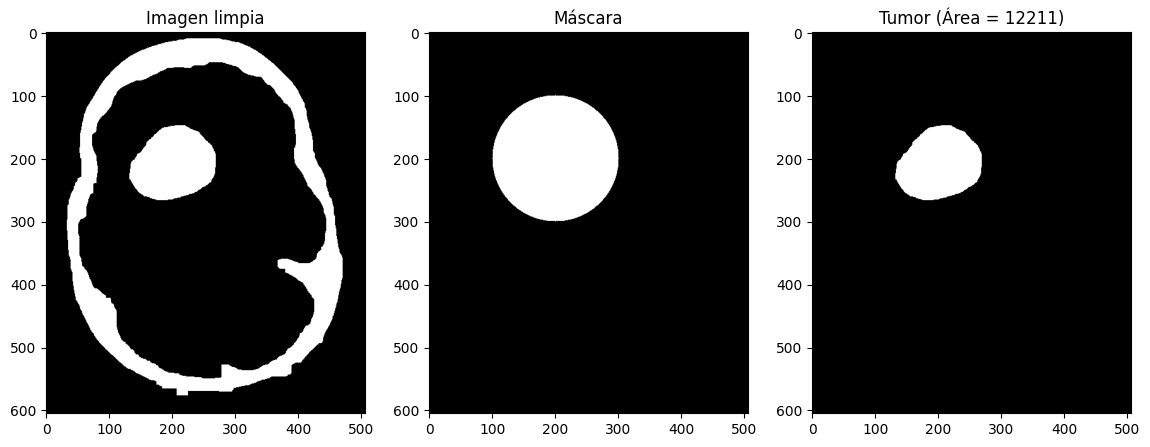

In [ ]:
filas, columnas = seg_standard.shape
mask = np.zeros((filas, columnas), np.float32)
r = 100
cv2.circle(mask, (200, 200), r, 1, -1)
tumor = noiseFree * mask
tumor = tumor.astype(np.uint8)
area = 0
for i in range(filas):
  for j in range(columnas):
    if tumor[i][j] == 255:
      area += 1

# Mostrar resultado
# Imagen limpia
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1)
plt.imshow(noiseFree, cmap='gray')
plt.title(f'Imagen limpia')

# Erosión
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title(f'Máscara')

# Erosión
plt.subplot(1, 3, 3)
plt.imshow(tumor, cmap='gray')
plt.title(f'Tumor (Área = {area})')
plt.show()